In [1]:
#import stuff
import os
import sys
import arrow
import numpy as np
import pandas as pd
from math import pi
import seaborn as sns
from datetime import datetime
from numpy import nan_to_num
import icartt
import decimal

In [2]:
filename = 'C:/Users/cphal/Desktop/MAC prediction model/FIREXAQ-LARGE-CDP_DC8_20190722_R0.ict'

In [4]:
#function purpose: extract diameter input for FIREXAQ:
def extract_diameters_firexaq(filename, starting_string, bin_location, num_others_beginning,num_others_end, spacer):
    f = open(filename)
    nextline = f.readline()

    #extract and ignore the data we don't care about
    while '-9999' not in nextline:
        nextline = f.readline()

    #extract variables at the beginning that we don't care about
    for x in range(num_others_beginning):
        nextline = f.readline()

    #create list to store description of variables (to extract bin sizes from)
    list_bin_descriptions = []
    nextline = f.readline()
    while len(nextline) > 10:
        nextrow = nextline.split(',')
        list_bin_descriptions.append(nextrow)
        nextline = f.readline()
    
    #build list of bin sizes, exracting variables at the end that we don't care about
    bin_size_description = []
    for x in range(len(list_bin_descriptions)-num_others_end):
        bin_size_description.append(list_bin_descriptions[x][bin_location])

    #create new list with just the numbers
    bin_sizes = []
    
    for x in range(len(bin_size_description)):
        #extract beginning of description
        string_length = len(starting_string) + spacer
        #build number and add to list
        str1 = bin_size_description[x]
        str1.replace(" ", "_")
        c = str1[string_length]
        new_bin_size = ''
        while(c != 'u'):
            new_bin_size = new_bin_size + c
            string_length += 1
            c = str1[string_length]
        bin_sizes.append(float(new_bin_size))

    size_dist_diameter_input = pd.Series(bin_sizes)
    return size_dist_diameter_input        
    
    f.close()

#UNITS: um (find way to remember this and implement it)

In [5]:
def extract_diameters_las(filename, starting_string, tag):
    f = open(filename)
    nextline = f.readline()

    #extract and ignore the data we don't care about
    while tag not in nextline:
        nextline = f.readline()

    #create new list with just the numbers
    list_row = nextline[len(starting_string):len(nextline)]
    bin_sizes = list_row.split(",")

    #delete unneeded ones
    bin_sizes.remove('\n')

    size_dist_diameter_input = pd.Series(bin_sizes)
    return size_dist_diameter_input 
    
    f.close()

filename = "C:/Users/cphal/Desktop/MAC prediction model/FIREXAQ-LARGE-LAScold_DC8_20190716_R0.ict"
tag = "OTHER_COMMENTS"
starting_string = "OTHER_COMMENTS: Midpoint diameters of Bins 00 to 79 determined by DMA-classified ammonium sulfate calibrations are: "
size_dist_diameter_input = extract_diameters_las(filename,starting_string,tag)     

In [6]:
file_details = pd.read_csv('C:/Users/cphal/Desktop/NOAA_Data/module_a_details.csv')
#FIXME: make file beginning an input parameter
file_beginning = 'FIREXAQ-LARGE-CDP_DC8_'

index = 0
for i in range(len(file_details)):
    if file_beginning in file_details.iloc[i,0]:
        index = i

starting_string = str(file_details.iloc[index,2])
tag = str(file_details.iloc[index,3])
bin_location = int(file_details.iloc[index,4])
num_others_beginning = int(file_details.iloc[index,5])
num_others_end = int(file_details.iloc[index,6])
spacer = int(file_details.iloc[index,7])

#print(file_details)

In [7]:
#filename = 'C:/Users/cphal/Desktop/MAC prediction model/FIREXAQ-LARGE-CDP_DC8_20190722_R0.ict'
#starting_string = 'number_size_distribution_dNdlogD_at_bin_center_'
#bin_location = 3
#num_others_beginning = 2
#num_others_end = 0
#spacer = 1

#filename = 'C:/Users/cphal/Desktop/MAC prediction model/FIREXAQ-LARGE-CPSPD_DC8_20190722_R0.ict'
#starting_string = ' bin center EQ '
#bin_location = 4
#num_others_beginning = 2
#num_others_end = 1
#spacer = 0

size_dist_diameter_input = extract_diameters_firexaq(filename, starting_string, bin_location, num_others_beginning, num_others_end, spacer)

#load in ict file to python (FIXME: delete later)
ict = icartt.Dataset(filename)
df = ict.data[:]
varnames = [x for x in ict.variables]
df = pd.DataFrame(df, columns = varnames)

ValueError: could not convert string to float: 'dlogD) meas'

In [6]:
#put first column into datetime file; next two columns are nCDP and vCDP
#last columns are the bins - size_dist_input

#time after midnight from dataframe - may not be needed
#datetime = df['Time_mid']
#totalCDP = df[['nCDP','vCDP']]

binnames = varnames[num_others_beginning+1:len(varnames)-num_others_end]
size_dist_input_original = df[binnames]

In [7]:
#transpose size_dist_input to get it to work with Module A
size_dist_input = pd.DataFrame.transpose(size_dist_input_original)

In [8]:
#Implement Module A (w/o merge) (these are the dividing lines)
#Note: check units
d_N1 = int(10.5)
d_N2 = int(30)
d_V1 = int(25)
d_V2 = int(40)

In [9]:
# If the selected size classes are broader than the measured aerosol sizes 
print (d_N1,d_N2,d_V1,d_V2,size_dist_diameter_input[len(size_dist_diameter_input)-1])
if (d_N1 < size_dist_diameter_input[0]):  #only large particles is available
    N1=0; F_N1=0  
    print("violation of: d_N1 < size_dist_diameter_input[0]")
if (d_N2 > size_dist_diameter_input[len(size_dist_diameter_input)-1]):  #only small particles is available
    N3=0; F_N3=0
    print("violation of: d_N2 > size_dist_diameter_input[len(size_dist_diameter_input)-1]")
if (d_V1 < size_dist_diameter_input[0]):
    V1=0; F_V1=0
    print("violation of: d_V1 < size_dist_diameter_input[0]")
if (d_V2 > size_dist_diameter_input[len(size_dist_diameter_input)-1]):
    V3=0; F_V=0
    print("violation of: d_V2 > size_dist_diameter_input[len(size_dist_diameter_input)-1]")

10 30 25 40 49.0


In [10]:
date_time = ict.times
datetimedf = pd.DataFrame(date_time, columns= ['datetime'])
num1 = str(date_time[0])
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.000000000')

In [11]:
#calculate dVdlogdP using dNdlogdP
diameter_power = np.power(size_dist_diameter_input, 3)
diameter_power = diameter_power.to_numpy()
size_dist_volume = pi/6*size_dist_input.mul(diameter_power,axis='index')

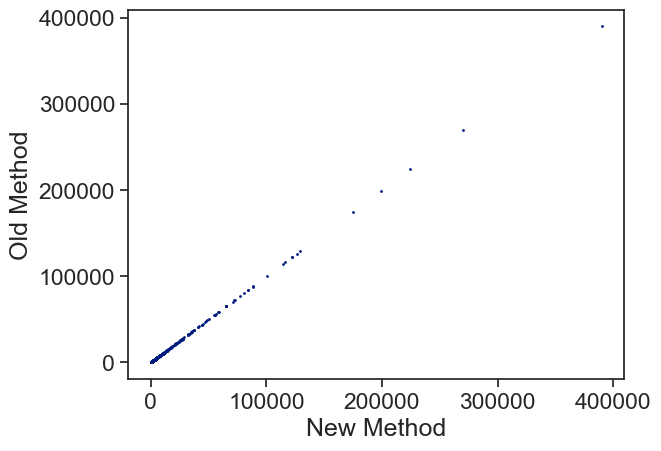

In [43]:
import matplotlib.pyplot as plt
#x_axis = size_dist_volume[3000]
#x_axis.append(size_dist_volume[4000])
#y_axis = size_dist_volume_orig[3000]
#y_axis.append(size_dist_volume_orig[4000])
x_axis = size_dist_volume
y_axis = size_dist_volume_orig
plt.scatter(x_axis,y_axis,s=1)
plt.xlabel('New Method')
plt.ylabel('Old Method')
plt.show()

In [12]:
N1 = np.zeros(np.size(size_dist_input,1)); N2 = np.zeros(np.size(size_dist_input,1)); N3 = np.zeros(np.size(size_dist_input,1))
F_N1 = np.zeros(np.size(size_dist_input,1)); F_N2 = np.zeros(np.size(size_dist_input,1)); F_N3 = np.zeros(np.size(size_dist_input,1))   
areaXY_number = np.zeros(np.size(size_dist_input,1))  
V1 = np.zeros(np.size(size_dist_input,1)); V2 = np.zeros(np.size(size_dist_input,1)); V3 = np.zeros(np.size(size_dist_input,1))
F_V1 = np.zeros(np.size(size_dist_input,1)); F_V2 = np.zeros(np.size(size_dist_input,1)); F_V3 = np.zeros(np.size(size_dist_input,1))   
areaXY_volume = np.zeros(np.size(size_dist_input,1))

In [13]:
print(areaXY_number)

[0. 0. 0. ... 0. 0. 0.]


In [14]:
#prepare for trapz calculation
size_dist_input[np.isnan(size_dist_input)] = 0 
size_dist_volume[np.isnan(size_dist_volume)] = 0 

ln_size_dist_diameter_input=np.log(size_dist_diameter_input)

In [24]:
#function purpose: find nearest value (d_N1, d_N2, d_V1, d_V2) in numpy array (instrument measured diameters)
def find_nearest(array, value):
    n = [abs(i-value) for i in array]
    idx = n.index(min(n))
    return idx

In [25]:
print("Calculating...")
for m in range(np.size(size_dist_input,1)):

        d_N1_nearest = find_nearest(size_dist_diameter_input,d_N1)
        d_N2_nearest = find_nearest(size_dist_diameter_input,d_N2)
        d_V1_nearest = find_nearest(size_dist_diameter_input,d_V1)
        d_V2_nearest = find_nearest(size_dist_diameter_input,d_V2)
        areaXY_number[m] = np.trapz(size_dist_input.values[:,m], x=ln_size_dist_diameter_input)
        N1[m] = np.trapz(size_dist_input.values[0:d_N1_nearest,m], x=ln_size_dist_diameter_input[0:d_N1_nearest])
        N2[m] = np.trapz(size_dist_input.values[d_N1_nearest+1:d_N2_nearest,m], x=ln_size_dist_diameter_input[d_N1_nearest+1:d_N2_nearest])    
        N3[m] = np.trapz(size_dist_input.values[d_N2_nearest+1:,m], x=ln_size_dist_diameter_input[d_N2_nearest+1:])
        if(areaXY_number[m] != 0):
                F_N1[m] = N1[m]/areaXY_number[m]
                F_N2[m] = N2[m]/areaXY_number[m]       
                F_N3[m] = N3[m]/areaXY_number[m]

        areaXY_volume[m] = np.trapz(size_dist_volume.values[:,m], x=ln_size_dist_diameter_input)
        V1[m] = np.trapz(size_dist_volume.values[0:d_V1_nearest,m], x=ln_size_dist_diameter_input[0:d_V1_nearest])
        V2[m] = np.trapz(size_dist_volume.values[d_V1_nearest+1:d_V2_nearest,m], x=ln_size_dist_diameter_input[d_V1_nearest+1:d_V2_nearest])    
        V3[m] = np.trapz(size_dist_volume.values[d_V2_nearest+1:,m], x=ln_size_dist_diameter_input[d_V2_nearest+1:])
        if(areaXY_volume[m] != 0):
                F_V1[m] = V1[m]/areaXY_volume[m]
                F_V2[m] = V2[m]/areaXY_volume[m]     
                F_V3[m] = V3[m]/areaXY_volume[m]

In [26]:
file_M_1 = pd.DataFrame() 
file_M_1['datetime'] = datetimedf
file_M_1['N1'] = N1; file_M_1['N2'] = N2 ; file_M_1['N3'] = N3 ; file_M_1['N_total'] = areaXY_number 
file_M_1['F_N1'] = F_N1; file_M_1['F_N2'] = F_N2 ; file_M_1['F_N3'] = F_N3 
file_M_1['V1'] = V1; file_M_1['V2'] = V2 ; file_M_1['V3'] = V3 ; file_M_1['V_total'] = areaXY_volume 
file_M_1['F_V1'] = F_V1; file_M_1['F_V2'] = F_V2 ; file_M_1['F_V3'] = F_V3 

In [27]:
print(file_M_1)

                 datetime        N1   N2   N3   N_total  F_N1  F_N2  F_N3  \
0     2019-07-22 18:15:40  0.000000  0.0  0.0  0.000000   0.0   0.0   0.0   
1     2019-07-22 18:15:41  0.000000  0.0  0.0  0.000000   0.0   0.0   0.0   
2     2019-07-22 18:15:42  0.000000  0.0  0.0  0.000000   0.0   0.0   0.0   
3     2019-07-22 18:15:43  0.000000  0.0  0.0  0.000000   0.0   0.0   0.0   
4     2019-07-22 18:15:44  0.000000  0.0  0.0  0.000000   0.0   0.0   0.0   
...                   ...       ...  ...  ...       ...   ...   ...   ...   
24741 2019-07-23 01:08:01  0.007244  0.0  0.0  0.007244   1.0   0.0   0.0   
24742 2019-07-23 01:08:02  0.000000  0.0  0.0  0.000000   0.0   0.0   0.0   
24743 2019-07-23 01:08:03  0.204961  0.0  0.0  0.204961   1.0   0.0   0.0   
24744 2019-07-23 01:08:04  0.007671  0.0  0.0  0.007671   1.0   0.0   0.0   
24745 2019-07-23 01:08:05  0.221747  0.0  0.0  0.221747   1.0   0.0   0.0   

              V1   V2   V3    V_total  F_V1  F_V2  F_V3  
0       0.000000 